In [1]:
import logging
import pandas as pd
import numpy as np
import jieba
import random
from gensim.models import word2vec

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
from torch.autograd import Variable
from sklearn.metrics import accuracy_score

# w2v

## split data

In [5]:
# Loading dataset
train = pd.read_csv('train.csv')
train
val = pd.read_csv('validation.csv')
val

,Content,Label
0,我有個國小認識的好朋友，上了大學後常常會跟我訴苦，大多是關於人際關係的他個性比較內向，不容易...,0
1,(第一人稱視角，)媽媽跟爸爸從我出生就感情不好 所以國小時離婚了我喜歡媽媽 不喜歡爸爸但我們...,1
2,我的前任在自殺前一周突然幫我慶生，一天前找我出門玩，再一聲不吭的自我了斷，給我很大的陰影。現...,0
3,身為一個亞斯伯格症的人看到這則新聞還蠻難過的首先我可以理解家長看到自己小孩無緣無故被攻擊而想...,0
4,真的很長，防雷。26個年頭來，經歷了大小事情。媽媽在國小開始因為經濟不景氣、收店的壓力、被朋...,0
...,...,...
402,請問吞藥自殺比較好呢？還是上吊？還是割脘呢？,1
403,到底要有多深的自我厭惡，才會夢到自傷、自殺？前幾天我做了一個夢，我覺得是近期做過最糟糕的夢了...,1
404,人總有過想死的念頭。有人說過如果你沒有想死過，那代表你沒真正活過。「呸呸呸，亂講話」當自己的...,1
405,這些年來過的生活都一樣沒有上課的時間都是待在家裡直到現在要畢業了也都差不多對任何事情也都無感...,1


In [4]:
## 取200筆非自殺
# train_neg = train[train["Label"] == 0].iloc[:200]
# train_pos = train[train["Label"] == 1]
# train = pd.concat([train_neg,train_pos])
# train = train.reset_index(drop=True)
# train

In [6]:
total = pd.concat([train, val])
total = total.reset_index(drop=True)
total_0 = total[total["Label"] == 0]
total_1 = total[total["Label"] == 1]
total_1

,Content,Label
0,仙草加蜂蜜好好吃！等下再去市場買一塊大仙草~吃吃吃好像把今天的熱量扣打吃完了-----Sen...,0
1,啊啊啊 邁入老女人的里程碑了今天本來想請假的但被同事搶先了然後從禮拜六開始爸爸媽媽就滿滿的情...,0
2,今天同事提出，覺得我有點過度依賴男友了不是第一個人說出這個問題其實早在交往的一開始我自己就察...,0
3,開始停速悅的這幾天我還是會吃安立平總覺得現在除了心悸手抖頭很重以外一直還有個在耳邊敲打小軍鼓...,0
4,我覺得有些善意的謊言是可以說的就是那些不會被揭穿的但有一些是一定會被揭穿「你狀態不好的時侯可...,0
...,...,...
1757,請問吞藥自殺比較好呢？還是上吊？還是割脘呢？,1
1758,到底要有多深的自我厭惡，才會夢到自傷、自殺？前幾天我做了一個夢，我覺得是近期做過最糟糕的夢了...,1
1759,人總有過想死的念頭。有人說過如果你沒有想死過，那代表你沒真正活過。「呸呸呸，亂講話」當自己的...,1
1760,這些年來過的生活都一樣沒有上課的時間都是待在家裡直到現在要畢業了也都差不多對任何事情也都無感...,1


In [13]:
# Label_1
num_1 = total_1.shape[0]
random_1 = random.sample(range(num_1), num_1)
train_1 = total_1.iloc[random_1[:207]]
test_1 = total_1.iloc[random_1[207:295]]
# Label_0
num_0 = total_0.shape[0]
random_0 = random.sample(range(num_0), num_0)
train_0 = total_0.iloc[random_0[:210]]
test_0 = total_0.iloc[random_0[210:300]]
# train_val_1
train_val_1 = train_1.shape[0]
random_train_val = random.sample(range(train_val_1), train_val_1)
train__1 = train_1.iloc[random_train_val[:186]]
val_1 = train_1.iloc[random_train_val[186:207]]
# train_val_0
train_val_0 = train_0.shape[0]
random_train_val = random.sample(range(train_val_0), train_val_0)
train__0 = train_0.iloc[random_train_val[:189]]
val_0 = train_0.iloc[random_train_val[189:210]]
# train_val
train = pd.concat([train__1, train__0])
train = train.reset_index(drop=True)
val = pd.concat([val_1, val_0])
val = val.reset_index(drop=True)
# test
test = pd.concat([test_1, test_0])
test = test.reset_index(drop=True)

## tokenized

In [7]:
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

# jieba custom setting.
jieba.set_dictionary('jieba_dict/dict.txt.big')

# load stopwords set
stopword_set = set()
with open('jieba_dict/stopwords.txt','r', encoding='utf-8') as stopwords:
    for stopword in stopwords:
        stopword_set.add(stopword.strip(' \n'))

In [8]:
def jieba_tokenizer(content):
    if str(content)=='nan':
        return ''
    words = jieba.cut(content.replace(' ',''))
    return [word for word in words if word not in stopword_set]

In [9]:
from ckiptagger import data_utils
from ckiptagger import WS, POS, NER
ws=WS("ckip")
pos=POS("ckip")
ner=NER("ckip")

/home/ubuntu/anaconda3/envs/lstm/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/ubuntu/anaconda3/envs/lstm/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/ubuntu/anaconda3/envs/lstm/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/ubuntu/anaconda3/envs/lstm/lib/python3.7/site-

In [10]:
def ckip_tokenizer(content):
#     if str(content)=='nan':
#         return ''
    word_s = ws([content])
    return word_s

In [16]:
train['tokenized'] = train.loc[:, 'Content'].apply(ckip_tokenizer)
val['tokenized'] = val.loc[:, 'Content'].apply(ckip_tokenizer)
test['tokenized'] = test.loc[:, 'Content'].apply(ckip_tokenizer)
val['tokenized']
# total['tokenized'] = total.loc[:, 'Content'].apply(ckip_tokenizer)
# total['tokenized']

0     [[滿, 腦子, 都, 是, 自殺, ., ., ., ., 搜尋, 紀錄, 也, 是, 自...
1     [[後悔, 昨天, 沒有, 將, 刀, 刺進, 喉嚨, 痛恨, 自己, 的, 軟弱, 無力,...
2     [[請問, 版友, 們, 有, 人, 有, 住院, 過, 的, 經驗, 嗎, ？, 醫師, ...
3     [[(, ., ., ., 續, ),  , (, 雷, ), He who has a w...
4     [[我, 需要, 人, 哄, 我, 情緒, 會, 起伏, 不定, 我, 除了, 名牌貨, 不...
5     [[事情, 要, 從, 國中, 甚至, 是, 從, 我, 五, 歲, 開始, 講起, 我, ...
6     [[如, 題, 我, 的, 憂鬱症, 發作, 了, 人, 現在, 在, 醫院, 裡, 等待,...
7     [[一直, 想, 自殺,  , 但, 都, 找, 不, 到, 可以, 100%, 自殺, 的...
8     [[我, 身為, 人, 真的, 很, 失敗, ，, 重度, 憂鬱症, ，, 社交, 恐懼症,...
9     [[魯迅, 說, 過, ，, 人, 的, 痛苦, 並, 不, 相通, 。, 我, 想說, ，...
10    [[文長, 。, 睡, 前, 被, 悠樂丁, 強制, 關機, 好像, 沒, 存, 到, 檔,...
11    [[我, 有時, 會, 憂鬱, 、, 很, 想, 死, ，, 認為, 自己, 沒有, 活, ...
12    [[已經, 連, 哭, 了, 三, 個, 小時, 一, 年, 都, 沒, 復發, 的, 憂鬱...
13    [[前, 女友, 離開, 這, 世界, 了, 直到, 收到, 消息, 我, 才, 發現, 我...
14    [[一直, 破, 了, 個, 洞, 怎麼, 都, 補, 不, 起來, 到底, 被, 挖走, ...
15    [[系館, 旁, 有, 一, 小, 片, 樹林, ，, 我們, 稱之為, 黑, 森林, 。,...
16    [[最近, 到, 了, 晚上, 都, 會, 想, 自殺,  , 想, 去, 診所, 諮詢, ...
17    [[好, 想, 自殺, 有, 人, 能, 陪, 我, 聊天, 嗎, 為什麼, 就, 

In [15]:
from gensim.models import KeyedVectors
w2v_model = KeyedVectors.load("w2v_ckip.model", mmap='r')

2021-02-27 15:03:26,162 : INFO : loading Word2VecKeyedVectors object from w2v_ckip.model
2021-02-27 15:03:32,971 : INFO : loading wv recursively from w2v_ckip.model.wv.* with mmap=r
2021-02-27 15:03:32,975 : INFO : loading vectors from w2v_ckip.model.wv.vectors.npy with mmap=r
2021-02-27 15:03:32,979 : INFO : setting ignored attribute vectors_norm to None
2021-02-27 15:03:32,982 : INFO : loading vocabulary recursively from w2v_ckip.model.vocabulary.* with mmap=r
2021-02-27 15:03:32,983 : INFO : loading trainables recursively from w2v_ckip.model.trainables.* with mmap=r
2021-02-27 15:03:32,983 : INFO : loading syn1neg from w2v_ckip.model.trainables.syn1neg.npy with mmap=r
2021-02-27 15:03:32,986 : INFO : setting ignored attribute cum_table to None
2021-02-27 15:03:32,987 : INFO : loaded w2v_ckip.model


In [18]:
# Retrieve the weights from the model. This is used for initializing the weights
# in a Keras Embedding layer later
w2v_weights = w2v_model.wv.vectors # If use pytorch add torch.from_numpy()
vocab_size, embedding_size = w2v_weights.shape
print("Vocabulary Size: {} - Embedding Dim: {}".format(vocab_size, embedding_size))

def word2token(word):
    try:
        return w2v_model.wv.vocab[word].index
    # If word is not in index return 0. I realize this means that this
    # is the same as the word of index 0 (i.e. most frequent word), but 0s
    # will be padded later anyway by the embedding layer (which also
    # seems dirty but I couldn't find a better solution right now)
    except KeyError:
        return 0
def token2word(token):
    return w2v_model.wv.index2word[token]

Vocabulary Size: 1096154 - Embedding Dim: 250


In [21]:
import copy
# total['word_vec'] = copy.deepcopy(total['tokenized'])
# for i in range(len(total)):
#     total['word_vec'][i] = total['tokenized'][i][0]
# total
train['word_vec'] = copy.deepcopy(train['tokenized'])
for i in range(len(train)):
    train['word_vec'][i] = train['tokenized'][i][0]
val['word_vec'] = copy.deepcopy(val['tokenized'])
for i in range(len(val)):
    val['word_vec'][i] = val['tokenized'][i][0]
test['word_vec'] = copy.deepcopy(test['tokenized'])
for i in range(len(test)):
    test['word_vec'][i] = test['tokenized'][i][0]

/home/ubuntu/anaconda3/envs/lstm/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/home/ubuntu/anaconda3/envs/lstm/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [22]:
# for i in range(len(total)):
#     for j in range(len(total['word_vec'][i])):
#         total['word_vec'][i][j] = word2token(total['word_vec'][i][j])
for i in range(len(train)):
    for j in range(len(train['word_vec'][i])):
        train['word_vec'][i][j] = word2token(train['word_vec'][i][j])
for i in range(len(val)):
    for j in range(len(val['word_vec'][i])):
        val['word_vec'][i][j] = word2token(val['word_vec'][i][j])
for i in range(len(test)):
    for j in range(len(test['word_vec'][i])):
        test['word_vec'][i][j] = word2token(test['word_vec'][i][j])

# LSTM

## Pytorch

In [ ]:
# def pad_samples(features, maxlen=250, PAD=0): #截長補短 讓長度一致，這裡固定文章長度為maxlen=250
#     padded_features = []
#     for feature in features:
#         if len(feature) >= maxlen:
#             padded_feature = feature[:maxlen]
#         else:
#             padded_feature = feature
#             while(len(padded_feature) < maxlen):
#                 padded_feature.append(PAD)
#         padded_features.append(padded_feature)
#     return padded_features

In [ ]:
# train_features = torch.tensor(pad_samples(train['word_vec']))
# vali_features = torch.tensor(pad_samples(vali['word_vec']))
# vali_features

In [ ]:
# # label_vec_to_torch.tensor
# train_labels = torch.tensor(train['Label'])
# vali_labels = torch.tensor(vali['Label'])
# vali_labels

In [ ]:
# ### create pytorch dataloader ###
# batch_size = 64
# train_set = torch.utils.data.TensorDataset(train_features, train_labels)
# train_iter = torch.utils.data.DataLoader(train_set, batch_size=batch_size,shuffle=True)

# vali_set = torch.utils.data.TensorDataset(vali_features, vali_labels)
# vali_iter = torch.utils.data.DataLoader(vali_set, batch_size=batch_size,shuffle=True)

In [ ]:
# ### build model ###
# class RNN(nn.Module):
#     def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
#                  bidirectional, weight, labels, **kwargs):
#         super(RNN, self).__init__(**kwargs)
#         self.num_hiddens = num_hiddens
#         self.num_layers = num_layers
#         self.bidirectional = bidirectional
#         self.embedding = nn.Embedding.from_pretrained(weight)
#         self.embedding.weight.requires_grad = False
#         self.encoder = nn.LSTM(input_size=embed_size, hidden_size=self.num_hiddens,
#                                num_layers=num_layers, bidirectional=self.bidirectional,
#                                dropout=0.3)

#         if self.bidirectional:
#             self.linear1 = nn.Linear(num_hiddens * 4, labels)
#         else:
#             self.linear1 = nn.Linear(num_hiddens * 2, labels)



#     def forward(self, inputs):
#         embeddings = self.embedding(inputs)
#         states, hidden = self.encoder(embeddings.permute([1, 0, 2]))
#         encoding = torch.cat([states[0], states[-1]], dim=1) #if it's bidirectional, choose first and last output
#         outputs = self.linear1(encoding)

#         return outputs

# num_epochs = 10
# num_hiddens = 100
# num_layers = 2
# bidirectional = True
# labels = 2
# device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
# net = RNN(vocab_size=(vocab_size+1), embed_size=embedding_size,
#                    num_hiddens=num_hiddens, num_layers=num_layers,
#                    bidirectional=bidirectional, weight=w2v_weights,
#                    labels=labels)

# print(net)

In [ ]:
# net.to(device)
# loss_function = nn.CrossEntropyLoss() # ~ nn.LogSoftmax()+nn.NLLLoss()
# optimizer = optim.Adam(net.parameters())

# def train(net,num_epochs,loss_function,optimizer,train_iter,val_iter):
#     for epoch in range(num_epochs):
#         start = time.time()
#         train_loss, val_losses = 0, 0
#         train_acc, val_acc = 0, 0
#         n, m = 0, 0
#         net.train()
#         for feature, label in train_iter:
#             n += 1
#             optimizer.zero_grad()
#             feature = Variable(feature.to(device))
#             label = Variable(label.to(device))

#             score = net(feature)
#             loss = loss_function(score, label)
#             loss.backward()
#             optimizer.step()
#             train_acc += accuracy_score(torch.argmax(score.cpu().data,dim=1), label.cpu())
#             train_loss += loss

#         with torch.no_grad():
#             net.eval()
#             for val_feature, val_label in val_iter:
#                 m += 1
#                 val_feature = val_feature.to(device)
#                 val_label = val_label.to(device)
#                 val_score = net(val_feature)
#                 val_loss = loss_function(val_score, val_label)
#                 val_acc += accuracy_score(torch.argmax(val_score.cpu().data,dim=1), val_label.cpu())
#                 val_losses += val_loss

#         runtime = time.time() - start
#         print('epoch: %d, train loss: %.4f, train acc: %.2f, val loss: %.4f, val acc: %.2f, time: %.2f' %
#               (epoch, train_loss.data/n, train_acc/n, val_losses.data/m, val_acc/m, runtime))

#     #save final model
#     state = {
#             'epoch': epoch,
#             'state_dict': net.state_dict(),
#             'optimizer': optimizer.state_dict()
#             }
#     torch.save(state, os.path.join(model_save_path,'last_model.pt'))


# def predict(net,test_iter):
#     #state = torch.load(os.path.join(cwd,'checkpoint','epoch10_maxlen300_embed200.pt'),map_location=torch.device('cpu'))
#     #net.load_state_dict(state['state_dict'])
#     pred_list = []
#     true_list = []
#     softmax = nn.Softmax(dim=1)
#     with torch.no_grad():
#         net.eval()
#         for batch,label in test_iter:
#             output = net(batch.to(device))
#             pred_list.extend(torch.argmax(softmax(output),dim=1).cpu().numpy())
#             true_list.extend(label.cpu().numpy())

#     acc = accuracy_score(pred_list, true_list)
#     print('test acc: %f'%acc)

#     return acc,pred_list,true_list


# print('start to train...')
# train(net,num_epochs,loss_function,optimizer,train_iter,vali_iter)

# print('start to predict test set...')
# acc,pred_list,true_list = predict(net,test_iter)

# print('Done')

# Keras

In [24]:
x_train = train['word_vec']
x_val = val['word_vec']
x_test = test['word_vec']
x_val

0     [3010, 47736, 9562, 268046, 1964, 0, 0, 0, 0, ...
1     [11437, 18265, 0, 11, 4125, 189147, 17221, 236...
2     [21003, 710567, 288420, 6824, 4911, 6824, 6804...
3     [0, 0, 0, 0, 7513, 0, 0, 0, 6090, 0, 0, 22504,...
4     [13585, 352, 4911, 90619, 13585, 3863, 22, 154...
5     [2181, 117, 274147, 2104, 551, 268046, 274147,...
6     [13419, 7928, 13585, 852301, 32964, 11917, 500...
7     [468, 411, 1964, 0, 8270, 9562, 2130, 37902, 3...
8     [13585, 4089, 4911, 2967, 928334, 1064, 0, 224...
9     [8145, 67, 149, 0, 4911, 852301, 5701, 255305,...
10    [368999, 0, 8618, 21, 0, 0, 3999, 36339, 8771,...
11    [13585, 1298, 22, 10365, 0, 928334, 411, 323, ...
12    [277, 962, 6113, 500766, 16, 606803, 317, 566,...
13    [21, 2546, 539, 0, 50, 500766, 507, 3291, 1576...
14    [468, 3177, 500766, 606803, 6557, 4395, 9562, ...
15    [62525, 1273, 6824, 566, 5775, 302, 8380, 0, 0...
16    [2503, 393624, 500766, 1113, 9562, 22, 411, 19...
17    [36487, 411, 1964, 6824, 4911, 72, 7921, 1

In [25]:
# label_vec
y_train = np.asarray(train['Label'])
y_val = np.asarray(val['Label'])
y_test = np.asarray(test['Label'])
y_val

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [26]:
# 建立 LSTM 架構
from keras import Input, losses, metrics
from keras.layers import Embedding, LSTM, concatenate, Dense, Bidirectional
from keras.models import Model, load_model
from keras.models import Sequential
from keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [27]:
# Sequences will be padded or truncated to this length
MAX_SEQUENCE_LENGTH = 250

input = Input(
    shape=(MAX_SEQUENCE_LENGTH, ), 
    dtype='int32')

In [28]:
x_train = pad_sequences(x_train, maxlen=MAX_SEQUENCE_LENGTH, padding='post', value=0)
x_val = pad_sequences(x_val, maxlen=MAX_SEQUENCE_LENGTH, padding='post', value=0)
x_test = pad_sequences(x_test, maxlen=MAX_SEQUENCE_LENGTH, padding='post', value=0)
len(x_val[0])

250

In [25]:
# del model

In [31]:
# Keras Embedding layer with Word2Vec weights initialization
model = Sequential()
model.add(Embedding(input_dim=vocab_size,
                    output_dim=embedding_size,
                    weights=[w2v_weights],
                    input_length=MAX_SEQUENCE_LENGTH,
                    mask_zero=True,
                    trainable=False))

model.add(Bidirectional(LSTM(125)))
model.add(Dense(16, activation='relu'))
model.add(Dense(units=1, activation='sigmoid'))

model.compile(optimizer='adam', loss=losses.binary_crossentropy, metrics=[metrics.binary_accuracy])

history = model.fit(x_train, y_train, epochs=10, batch_size=114,
                    validation_data=(x_val, y_val), verbose=1)

Train on 375 samples, validate on 42 samples
Epoch 1/10
375/375 [==============================] - 13s 35ms/step - loss: 0.7001 - binary_accuracy: 0.4747 - val_loss: 0.6829 - val_binary_accuracy: 0.5714
Epoch 2/10
375/375 [==============================] - 7s 18ms/step - loss: 0.6478 - binary_accuracy: 0.6800 - val_loss: 0.6719 - val_binary_accuracy: 0.5714
Epoch 3/10
375/375 [==============================] - 12s 31ms/step - loss: 0.5949 - binary_accuracy: 0.7333 - val_loss: 0.6494 - val_binary_accuracy: 0.7143
Epoch 4/10
375/375 [==============================] - 14s 37ms/step - loss: 0.5332 - binary_accuracy: 0.7733 - val_loss: 0.7048 - val_binary_accuracy: 0.6190
Epoch 5/10
375/375 [==============================] - 16s 43ms/step - loss: 0.5083 - binary_accuracy: 0.7653 - val_loss: 0.6255 - val_binary_accuracy: 0.7143
Epoch 6/10
375/375 [==============================] - 12s 31ms/step - loss: 0.4888 - binary_accuracy: 0.7760 - val_loss: 0.6192 - val_binary_accuracy: 0.7143
Epoch 7/

In [38]:
#model.save('lstm_635.h5')

In [4]:
model = load_model('lstm_635.h5')
model.summary()

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 250, 250)          220989500 
_________________________________________________________________
bidirectional_4 (Bidirection (None, 250)               376000    
_________________________________________________________________
dense_3 (Dense)              (None, 16)                4016      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 17        
Total params: 221,369,533
Trainable params: 380,033
Non-trainable params: 220,989,500
_________________________________________________________________


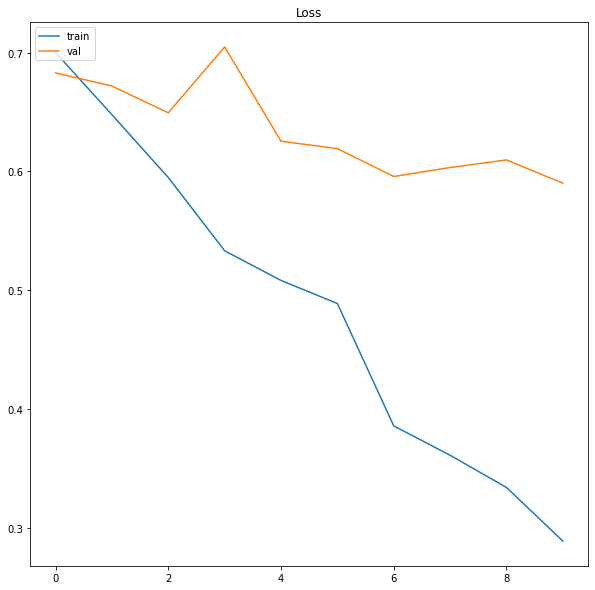

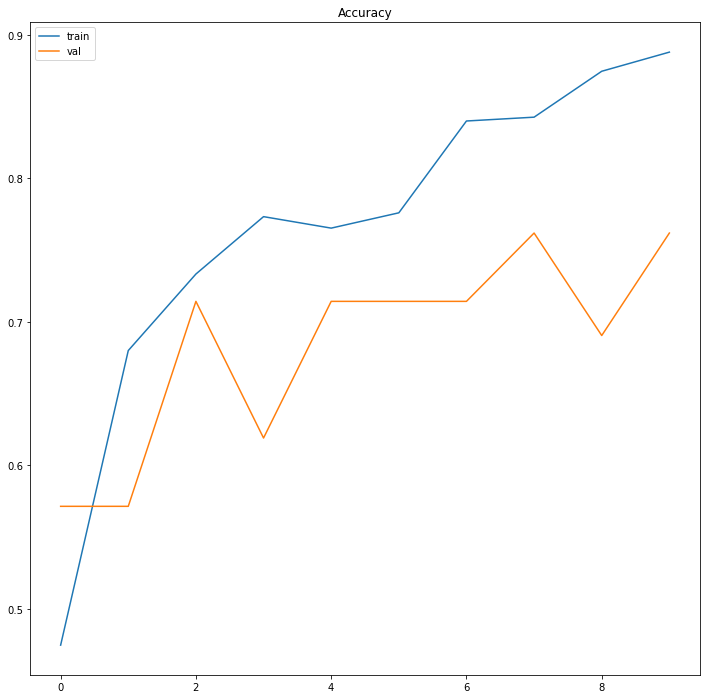

In [32]:
# Plotting Loss and Accuracy Graphs
plt.figure(figsize=(10, 10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure(figsize=(12, 12))
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('Accuracy')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [33]:
from sklearn.metrics import classification_report
import itertools
from sklearn.metrics import confusion_matrix

In [34]:
y_predict = model.predict(x_test, batch_size=None, verbose=0, steps=None)
y_predict

array([[0.5746208 ],
       [0.10834089],
       [0.11915174],
       [0.81216586],
       [0.9657968 ],
       [0.96674573],
       [0.38147217],
       [0.16760299],
       [0.25107732],
       [0.7876576 ],
       [0.7739028 ],
       [0.7953123 ],
       [0.88392556],
       [0.95651555],
       [0.9172292 ],
       [0.96282935],
       [0.71252656],
       [0.5873734 ],
       [0.94678915],
       [0.3746267 ],
       [0.22430298],
       [0.08523712],
       [0.05792916],
       [0.89034843],
       [0.0267781 ],
       [0.8642738 ],
       [0.3917554 ],
       [0.8104831 ],
       [0.9050622 ],
       [0.8407141 ],
       [0.22537982],
       [0.9896333 ],
       [0.7268631 ],
       [0.94197845],
       [0.8830228 ],
       [0.0876869 ],
       [0.89536816],
       [0.08264175],
       [0.8156243 ],
       [0.5387742 ],
       [0.18945089],
       [0.9049673 ],
       [0.25424471],
       [0.55948025],
       [0.96233535],
       [0.43597683],
       [0.89104074],
       [0.423

In [35]:
predict = []
for i in range(len(y_predict)):
    if y_predict[i] > 0.5:
        predict.append(1)
    else:
        predict.append(0)
        
predict

[1,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0]

In [36]:
# confusion matrix
matrix = confusion_matrix(y_test,predict, labels=[1,0])
print("accuracy score:", accuracy_score(y_test, predict))
print('Confusion matrix : \n',matrix)

accuracy score: 0.6685393258426966
Confusion matrix : 
 [[57 31]
 [28 62]]


In [37]:
# classification report for precision, recall f1-score and accuracy
matrix = classification_report(y_test,predict,labels=[1,0])
print('Classification report : \n',matrix)

Classification report : 
               precision    recall  f1-score   support

           1       0.67      0.65      0.66        88
           0       0.67      0.69      0.68        90

    accuracy                           0.67       178
   macro avg       0.67      0.67      0.67       178
weighted avg       0.67      0.67      0.67       178



In [118]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Oranges):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Normalized confusion matrix
[[1. 0.]
 [1. 0.]]


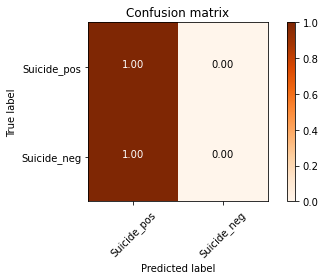

In [119]:
y_pred = predict

#y_pred = convert_to_labels(y_predict)
y_true = y_test
target_names = [ 'Suicide_pos','Suicide_neg']
#print(classification_report(y_true, y_pred, target_names=target_names))

plt.figure()
cnf_matrix = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(cnf_matrix, classes=target_names,normalize=True)

plt.show()